# <center>Minimum Transformation Method
## <center>An inverse model for inferring surface fluxes and mixing from gridded hydrographic TS data, <br> by Taimoor Sohail and Jan D. Zika (2021)

##### <center>This code lays out a framework for inferring ocean circulation, mixing and surface flux changes between 2006-2011 and 2011-2017 from gridded observational TS data (EN4). We use an optimal transport method, minimzing a cost function which respects the volume and mass conservation, and the fundamental physics of mixing in TS space. <br>See also: Jan D Zika et al. (2021) [www.doi.org/10.1175/JCLI-D-20-0355.1 ] for a simpler version of this model which optimizes ocean circulation only.
 

-----
## Remove this section prior to publication~~
 
 ## Left to do:
 - Look at K-means clustering instead of quadtree, either on the distribution or 3D ocean?
 - Tweak cost function to include distance/age/velocity weighting?
 

-------------------------------------
# Load the relevant modules and functions for the calculation
-------------------------------------

In [1]:
# Modules to output runtimes for each code cell (for slower code)
import time
from tqdm.notebook import tqdm

# Suppress spurious warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')

# Modules needed to read the files and handle array computations
import xarray as xr
import scipy.io as spio
import numpy as np

# Module to do the TS binning 
from scipy import stats

# Change the system recursion limit to allow finer quadtree compression
import sys 
sys.setrecursionlimit(100000)

# Module to perform the optimization
import cvxpy as cp

# Modules to plot outputs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as cr

# Specify font properties for plots
from matplotlib import rc
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

rc('font', **font)

## Define 'Parula' colormap from Matlab

In [2]:

from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

## Define a function which accurately extracts matlab data preserving structures in the extraction and converting them to Python dictionaries

In [3]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## For each basin we use a custom-built weighted quadtree method to refine the T-S grid where the change in volume between the early and late period is greater than 'threshold'.

In [4]:
# Define a class in which data is input
class Data():
    def __init__(self, x, y, weight, v1):
        self.x = x
        self.y = y
        self.w = weight
        self.v1 = v1

class Node():
    def __init__(self, x0, y0, w, h, data):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.data = data
        self.children = []

    def get_width(self):
        return self.width
    def get_height(self):
        return self.height    
    def get_data(self):
        return self.data

# Define a subdivision function

def recursive_subdivide(node, k):
    # Conditional that decides if Quadtree splits
    if sum(i.w for i in node.data)<=k:
        return
   
    w_ = float(node.width/2)
    h_ = float(node.height/2)

    p = contains(node.x0, node.y0, w_, h_, node.data)
    x1 = Node(node.x0, node.y0, w_, h_, p)
    recursive_subdivide(x1, k)

    p = contains(node.x0, node.y0+h_, w_, h_, node.data)
    x2 = Node(node.x0, node.y0+h_, w_, h_, p)
    recursive_subdivide(x2, k)

    p = contains(node.x0+w_, node.y0, w_, h_, node.data)
    x3 = Node(node.x0 + w_, node.y0, w_, h_, p)
    recursive_subdivide(x3, k)

    p = contains(node.x0+w_, node.y0+h_, w_, h_, node.data)
    x4 = Node(node.x0+w_, node.y0+h_, w_, h_, p)
    recursive_subdivide(x4, k)

    node.children = [x1, x2, x3, x4]

def contains(x, y, w, h, data):
    pts = []
    for datas in data:
        if datas.x >= x and datas.x <= x+w and datas.y>=y and datas.y<=y+h:
            pts.append(datas)
    return pts


def find_children(node):
    if not node.children:
        return [node]
    else:
        children = []
        for child in node.children:
            children += (find_children(child))
    return children

# Quadtree class which is invoked in main code and calls other sub-classes

class QTree():
    def __init__(self, k, x, y, weight, v1):
        self.threshold = k
        self.data = [Data(x[n], y[n], weight[n], v1[n]) for n in range(x.size)]
        self.root = Node(Smin, Tmin, Smax-Smin, Tmax-Tmin, self.data)

    def add_data(self, x, y, w):
        self.data.append(Data(x, y, w))
    
    def get_data(self):
        return self.data
    
    def subdivide(self):
        recursive_subdivide(self.root, self.threshold)
        
    def qtgetblk(self):
        c = find_children(self.root)
        size_new = np.zeros(len(c))
        qtout = []
        for el in range(len(c)):
            size_new[el] = int(np.array(np.array(c)[el].data).size)
            vals=0
            c_data = c[el].data
            for i in range(np.array(c_data).size):
                vals = vals+(c_data[i].v1)
            qtout.append([vals, int(size_new[el])])
        return qtout, len(c)

# Output total variable within each quadtree bin
    
def sum_children(threshold, SA_flat, CT_flat, flat_A, flat_A1):
    Qtree_area2 = QTree(threshold, SA_flat, CT_flat, flat_A, flat_A1)
    Qtree_area2.subdivide()
    qtout_list, c_length = Qtree_area2.qtgetblk()
    qtout_area2 = np.zeros((c_length, 2))
    for i in range(c_length):
        for j in range(2):
            qtout_area2[i, j] = qtout_list[i][j]
    return qtout_area2

# Output quadtree bin edge co-ordinates

def QT_edges(threshold, SA_flat, CT_flat, flat_A, flat_A1):
    Qtree_edges = QTree(threshold, SA_flat, CT_flat, flat_A, flat_A1)
    Qtree_edges.subdivide()
    c = find_children(Qtree_edges.root)
    S_start = np.zeros(len(c))
    S_end = np.zeros(len(c))
    T_start = np.zeros(len(c))
    T_end = np.zeros(len(c))
    i = 0
    for n in c:
        S_start[i] = n.x0
        S_end[i] = n.x0+n.width
        T_start[i] = n.y0
        T_end[i] = n.y0+n.height    
        i = i + 1    
    return  S_start, S_end, T_start, T_end

-------
# Load data and define parameters
-------

These data include:    

| Parameter          | Description  |
|-------------|---|
| **CTearly, SAearly** | Monthly conservative temperature and practical salinity for January 2006 to December 2011   |  
| **CTlate, SAlate**            | Monthly conservative temperature January 2012 to December 2017    | 
| **lat, lon, z**            | Latitude, Longitude (degrees) and depth (m) all 1D    | 
| **darea**            | Area of each (lat,lon) grid point (m^2)  | 
| **vol**            | Volume of each (lat,lon,z) grid point (m^3)  | 
| **dyrs**            | Years between centre of early and late periods  | 
| **noyrs**            |  Number of years of early and late periods |  
| **AtlMask, IndMask, PacMask**            |  Atlantic, Indian and Pacific Ocean Masks | 
| **Basins**            | Abbreviated names of 9 distinct regions  | 
| **bloc - structure containing the following entries for each region:**            
|  **mask:**   |            Region mask (can be on (0,1) due to fuzzy edges)   |
|**name:**     |          Full name of region   |
|**connec:**   |          Connectivity to other regions (0=connected, 1=not)  |

EN4.1.1.analyses.g10 practical salinity and in-situ temperature data were downloaded from https://www.metoffice.gov.uk/hadobs/en4/download.html and converted to SA and CT using the MatlabGibbs Sea Water toolbox V3.03 (http://www.teos-10.org/software.htm).

## Load observational data

In [5]:
%%time
EN4_data = loadmat('MTM_demo_earlydata_EN4_20062011_latedata_EN4_200122017.mat')
CTearly =  EN4_data['CTearly']
SAearly = EN4_data['SAearly']
CTlate = EN4_data['CTlate']
SAlate = EN4_data['SAlate']
lat = EN4_data['lat']
lon = EN4_data['lon']
z = EN4_data['z']
darea = EN4_data['darea']
vol = EN4_data['vol']
dyrs = EN4_data['dyrs']
noyrs = EN4_data['noyrs']
AtlMask = EN4_data['AtlMask']
IndMask = EN4_data['IndMask']
PacMask = EN4_data['PacMask']
Basins = EN4_data['Basins']
bloc = EN4_data['bloc']
# Note that bloc is a dictionary in Python, and is interrogated via bloc['basin_name']['mask'/'name'/'connec']

CPU times: user 25.7 s, sys: 4.19 s, total: 29.9 s
Wall time: 30 s


## Define parameters

In [6]:
# Area (m^2) at which the quadtree method will stop splitting watermasses
threshold = .5*10**12
# Initial resolution of the T-S grid (power of 2; i.e. 128, 256, 512, etc)
num = 512
# Penalty on S vs T changes relative to beta/alpha (~4.28)
scalefact = 1
# Define outer limits of T-S grid
Smin = -5.2 
Smax = 46
Tmin = -6.4 
Tmax = 96

# Establish basic constants and TS grid
yr2sec = 365.25*24*60*60
Cp=4000
rho=1024
S0=35

# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4
ST_scale=scalefact*(bet/alph)

# Define T-S bin boundaries and centres
Srange = np.linspace(Smin, Smax, num+1)
Trange = np.linspace(Tmin, Tmax, num+1)
S_i = (Srange[1:]+Srange[:-1])/2
T_i = (Trange[1:]+Trange[:-1])/2
dS_grid = np.repeat(np.diff(Srange)[:,np.newaxis],S_i.size,axis=-1)
dT_grid = np.repeat(np.diff(Trange)[np.newaxis, :],T_i.size, axis=0)
S_grid = np.repeat(S_i[:,np.newaxis],T_i.size,axis=-1)
T_grid = np.repeat(T_i[np.newaxis, :],S_i.size,axis=0)
dT = dT_grid[0,0]
dS = dS_grid[0,0]

-----
## <center>Calculate TS distributions from monthly hydrographic data::
-----

 | Parameter   | Description |
 |-------------|-------------|
 | **V$_1$(T,S)** | Binned volume in early period (2006-2011) |
 | **V$_2$(T,S)** | Binned volume in late period (2011-2017) |
 | **TV$_1$(T,S)** | Binned temperature$\times$volume in early period (2006-2011) |
 | **TV$_2$(T,S)** | Binned temperature$\times$volume in late period (2011-2017) |
 | **SV$_1$(T,S)** | Binned salinity$\times$volume in early period (2006-2011) |
 | **SV$_2$(T,S)** | Binned salinity$\times$volume in late period (2011-2017) |

In [7]:
# %%time
# # $$v(T^*,S^*)=\frac{\partial^2}{\partial T\partial S}\int_{T<T^*,S<S^*}dV$$
# #
# # as in equation (2) of Zika et al. (2021).
# #
# # Volume, T*volume and S*volume for each region (early=1, late=2)
# V1 = np.zeros(((T_i).size,(S_i).size,(Basins).size))
# TV1 = np.zeros_like(V1)
# SV1 = np.zeros_like(V1)
# V2 = np.zeros_like(V1)
# TV2 = np.zeros_like(V1)
# SV2 = np.zeros_like(V1)

# for bx in range(Basins.size):
#     # Loop through each basin making the non-basin grid points zero volume 
#     VOLB = vol*bloc[Basins[bx]]['mask']
#     VOLB = np.where((bloc[Basins[bx]]['mask']!=0),  VOLB, np.nan)*(CTearly[:,:,:,0]/CTearly[:,:,:,0])
#     for tx in range (CTearly[0,0,0,:].size):
#         # Loop through each month grabbing T and S for that month and region  
#         T= CTearly[:,:,:,tx]
#         T = np.where((bloc[Basins[bx]]['mask']!=0),  T, np.nan)*(CTearly[:,:,:,0]/CTearly[:,:,:,0])
#         S = SAearly[:,:,:,tx]
#         S = np.where((bloc[Basins[bx]]['mask']!=0),  S, np.nan)*(CTearly[:,:,:,0]/CTearly[:,:,:,0])
#         TC = CTlate[:,:,:,tx]
#         TC = np.where((bloc[Basins[bx]]['mask']!=0),  TC, np.nan)*(CTearly[:,:,:,0]/CTearly[:,:,:,0])
#         SC = SAlate[:,:,:,tx]
#         SC = np.where((bloc[Basins[bx]]['mask']!=0),  SC, np.nan)*(CTearly[:,:,:,0]/CTearly[:,:,:,0])
#         # 2D binning for early period
#         a = np.ndarray.flatten(VOLB)
#         b = np.ndarray.flatten(T[:,:,:])*(a+10**-8)/(a+10**-8)
#         c = np.ndarray.flatten(S[:,:,:])*(a+10**-8)/(a+10**-8)
#         values,  x_edges, y_edges,  binnumber = stats.binned_statistic_2d(c,b,a,statistic='sum', bins=[Srange, Trange])
#         V1[:,:,bx] = V1[:,:,bx] + values
        
#         a = np.ndarray.flatten(VOLB*T)
#         b = np.ndarray.flatten(T[:,:,:])*(a+10**-8)/(a+10**-8)
#         c = np.ndarray.flatten(S[:,:,:])*(a+10**-8)/(a+10**-8)
#         values,  x_edges, y_edges,  binnumber = stats.binned_statistic_2d(c,b,a, statistic='sum', bins=[Srange, Trange])
#         TV1[:,:,bx] = TV1[:,:,bx] + values
        
#         a = np.ndarray.flatten(VOLB*S)
#         b = np.ndarray.flatten(T[:,:,:])*(a+10**-8)/(a+10**-8)
#         c = np.ndarray.flatten(S[:,:,:])*(a+10**-8)/(a+10**-8)
#         values,  x_edges, y_edges,  binnumber = stats.binned_statistic_2d(c,b,a, statistic='sum', bins=[Srange, Trange])
#         SV1[:,:,bx] = SV1[:,:,bx] + values
        
# #         # 2D binning for late period
#         a = np.ndarray.flatten(VOLB)
#         b = np.ndarray.flatten(TC[:,:,:])*(a+10**-8)/(a+10**-8)
#         c = np.ndarray.flatten(SC[:,:,:])*(a+10**-8)/(a+10**-8)
#         values,  x_edges, y_edges,  binnumber = stats.binned_statistic_2d(c,b,a, statistic='sum', bins=[Srange, Trange])
#         V2[:,:,bx] = V2[:,:,bx] + values
        
#         a = np.ndarray.flatten(VOLB*TC)
#         b = np.ndarray.flatten(TC[:,:,:])*(a+10**-8)/(a+10**-8)
#         c = np.ndarray.flatten(SC[:,:,:])*(a+10**-8)/(a+10**-8)
#         values,  x_edges, y_edges,  binnumber = stats.binned_statistic_2d(c,b,a, statistic='sum', bins=[Srange, Trange])
#         TV2[:,:,bx] = TV2[:,:,bx] + values
        
#         a = np.ndarray.flatten(VOLB*SC)
#         b = np.ndarray.flatten(TC[:,:,:])*(a+10**-8)/(a+10**-8)
#         c = np.ndarray.flatten(SC[:,:,:])*(a+10**-8)/(a+10**-8)
#         values,  x_edges, y_edges,  binnumber = stats.binned_statistic_2d(c,b,a, statistic='sum', bins=[Srange, Trange])
#         SV2[:,:,bx] = SV2[:,:,bx] + values      
# #     # I have not weighted the average by the number of days in each month. 
# V1 = V1/tx
# V2 = V2/tx
# TV1 = TV1/tx
# TV2 = TV2/tx
# SV1 = SV1/tx
# SV2 = SV2/tx

| Parameter   | Description |
|-------------|-------------|
| **A$_1$(T,S)** | Binned area in early period (2006-2011) |
| **A$_2$(T,S)** | Binned area in late period (2011-2017) |

In [8]:
# A1 = np.zeros(((T_i).size,(S_i).size,(Basins).size))
# A2 = np.zeros_like(A1)

# for bx in range(Basins.size):
#     # Loop through each basin making the non-basin grid points zero volume 
#     AREAB = darea*bloc[Basins[bx]]['mask'][:,:,0]
#     AREAB = np.where((bloc[Basins[bx]]['mask'][:,:,0]!=0),  AREAB, np.nan)*(CTearly[:,:,0,0]/CTearly[:,:,0,0])
#     for tx in range (CTearly[0,0,0,:].size):
#         # Loop through each month grabbing T and S for that month and region  
#         SST= CTearly[:,:,0,tx]
#         SST = np.where((bloc[Basins[bx]]['mask'][:,:,0]!=0),  SST, np.nan)*(CTearly[:,:,0,0]/CTearly[:,:,0,0])
#         SSS = SAearly[:,:,0,tx]
#         SSS = np.where((bloc[Basins[bx]]['mask'][:,:,0]!=0),  SSS, np.nan)*(CTearly[:,:,0,0]/CTearly[:,:,0,0])
#         SSTC = CTlate[:,:,0,tx]
#         SSTC = np.where((bloc[Basins[bx]]['mask'][:,:,0]!=0),  SSTC, np.nan)*(CTearly[:,:,0,0]/CTearly[:,:,0,0])
#         SSSC = SAlate[:,:,0,tx]
#         SSSC = np.where((bloc[Basins[bx]]['mask'][:,:,0]!=0),  SSSC, np.nan)*(CTearly[:,:,0,0]/CTearly[:,:,0,0])
#         # 2D binning for early period
#         a = np.ndarray.flatten(AREAB)
#         b = np.ndarray.flatten(SST[:,:])*(a+10**-8)/(a+10**-8)
#         c = np.ndarray.flatten(SSS[:,:])*(a+10**-8)/(a+10**-8)
#         values,  x_edges, y_edges,  binnumber = stats.binned_statistic_2d(c,b,a,statistic='sum', bins=[Srange, Trange])
#         A1[:,:,bx] = A1[:,:,bx] + values
#         a = np.ndarray.flatten(AREAB)
#         b = np.ndarray.flatten(SSTC[:,:])*(a+10**-8)/(a+10**-8)
#         c = np.ndarray.flatten(SSSC[:,:])*(a+10**-8)/(a+10**-8)
#         values,  x_edges, y_edges,  binnumber = stats.binned_statistic_2d(c,b,a, statistic='sum', bins=[Srange, Trange])
#         A2[:,:,bx] = A2[:,:,bx] + values
    
# A1 = A1/tx
# A2 = A2/tx

## Save variables into intermediate file (to avoid reprocessing if dataset is unchanged)

In [9]:
# np.savez('MinMaxTSdists.npz', V1,
# V2,
# TV1,
# TV2,
# SV1,
# SV2,
# A1,
# A2)

## Load variables from intermediate file

In [10]:
data = np.load('MinMaxTSdists.npz')

V1 = data['arr_0']
V2 = data['arr_1']
TV1 = data['arr_2']
TV2 = data['arr_3']
SV1 = data['arr_4']
SV2 = data['arr_5']
A1 = data['arr_6']
A2 = data['arr_7']

## Plot global mean TS distributions of V and A, as well as tendencies

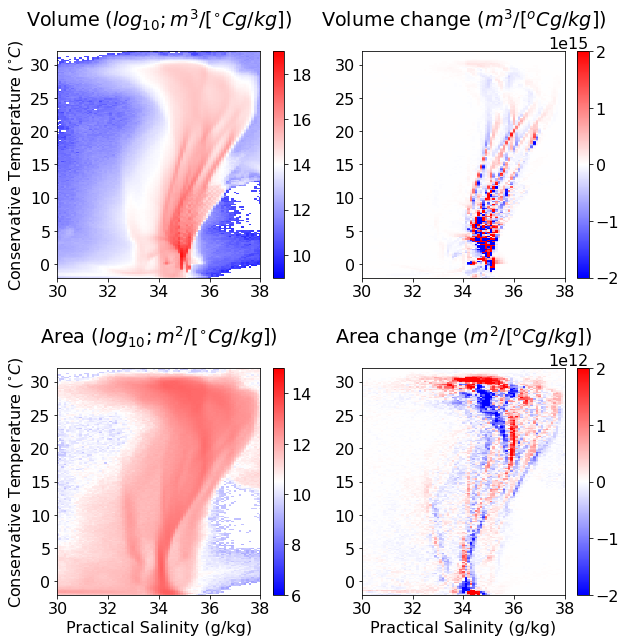

In [11]:
fig, axs = plt.subplots(2,2, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=0.2)
axs = axs.ravel()

im1 = axs[0].pcolormesh(S_i,T_i,np.moveaxis(np.log10(np.nansum((V1+V2)/2,axis=-1)/(dS_grid*dT_grid)),0,-1), \
                  cmap='bwr', vmin=9, vmax=19)
axs[0].set_title('Volume ($log_{10}; m^3/[^{\circ}Cg/kg]$)', pad=25)
# axs[0].set_xlabel('Practical Salinity (g/kg)')
axs[0].set_ylabel('Conservative Temperature ($^{\circ}C$)')
axs[0].set_xlim(30,38)
axs[0].set_ylim(-2,32)

im2 = axs[1].pcolormesh(S_i,T_i,np.moveaxis(np.nansum((V2-V1),axis=-1)/(dS_grid*dT_grid),0,-1), \
                  cmap='bwr', vmin=-2*10**15, vmax=2*10**15)
axs[1].set_title('Volume change ($m^3/[^oCg/kg]$)', pad=25)
# axs[1].set_xlabel('Practical Salinity (g/kg)')
axs[1].set_xlim(30,38)
axs[1].set_ylim(-2,32)

im3 = axs[2].pcolormesh(S_i,T_i,np.moveaxis(np.log10(np.nansum((A1+A2)/2,axis=-1)/(dS_grid*dT_grid)),0,-1), \
                  cmap='bwr', vmin=6, vmax=15)
axs[2].set_title('Area ($log_{10}; m^2/[^{\circ}Cg/kg]$)', pad=25)
axs[2].set_xlabel('Practical Salinity (g/kg)')
axs[2].set_ylabel('Conservative Temperature ($^{\circ}C$)')
axs[2].set_xlim(30,38)
axs[2].set_ylim(-2,32)

im4 = axs[3].pcolormesh(S_i,T_i,np.moveaxis(np.nansum((A2-A1),axis=-1)/(dS_grid*dT_grid),0,-1), \
                  cmap='bwr', vmin=-2*10**12, vmax=2*10**12)
axs[3].set_title('Area change ($m^2/[^oCg/kg]$)', pad=25)
axs[3].set_xlabel('Practical Salinity (g/kg)')
axs[3].set_xlim(30,38)
axs[3].set_ylim(-2,32)

fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])
fig.colorbar(im3, ax=axs[2])
fig.colorbar(im4, ax=axs[3])
plt.savefig('../../Figures/Init_TS_bins_MinMax.png', dpi=300, bbox_inches='tight')
plt.show()

----------
# Coarsen distributions using Quadtree
----------

## Use Quadtree to coarsen all variables [V, TV, SV, and A] based on a time-mean area threshold across entire time period (2006-2017)

In [12]:
%%time
XY = np.meshgrid(S_i, T_i)
SA_flat = np.ndarray.flatten(XY[0])
CT_flat = np.ndarray.flatten(XY[1])
qtout_basins_area1 = []
qtout_basins_area2 = []
qtout_basins_vol1 = []
qtout_basins_vol2 = []
qtout_basins_Svol1 = []
qtout_basins_Svol2 = []
qtout_basins_Tvol1 = []
qtout_basins_Tvol2 = []

S_avg1 = []
S_avg2 = []
T_avg1 = []
T_avg2 = []

for bx in tqdm(range(Basins.size)):
    flat_A = np.ndarray.flatten(np.moveaxis(((A1+A2)/2)[:,:,bx],0,-1))
    flat_A[np.isnan(flat_A)] = 0
    flat_A1 = np.ndarray.flatten(np.moveaxis(((A1))[:,:,bx],0,-1))
    flat_A1[np.isnan(flat_A1)] = 0
    flat_A2 = np.ndarray.flatten(np.moveaxis(((A2))[:,:,bx],0,-1))
    flat_A2[np.isnan(flat_A2)] = 0
    flat_V1 = np.ndarray.flatten(np.moveaxis(((V1))[:,:,bx],0,-1))
    flat_V1[np.isnan(flat_V1)] = 0
    flat_V2 = np.ndarray.flatten(np.moveaxis(((V2))[:,:,bx],0,-1))
    flat_V2[np.isnan(flat_V2)] = 0
    flat_SV1 = np.ndarray.flatten(np.moveaxis(((SV1))[:,:,bx],0,-1))
    flat_SV1[np.isnan(flat_SV1)] = 0
    flat_SV2 = np.ndarray.flatten(np.moveaxis(((SV2))[:,:,bx],0,-1))
    flat_SV2[np.isnan(flat_SV2)] = 0
    flat_TV1 = np.ndarray.flatten(np.moveaxis(((TV1))[:,:,bx],0,-1))
    flat_TV1[np.isnan(flat_TV1)] = 0
    flat_TV2 = np.ndarray.flatten(np.moveaxis(((TV2))[:,:,bx],0,-1))
    flat_TV2[np.isnan(flat_TV2)] = 0

    qtout_basins_area1.append(sum_children(threshold, SA_flat, CT_flat, flat_A, flat_A1))
    qtout_basins_area2.append(sum_children(threshold, SA_flat, CT_flat, flat_A, flat_A2))
    qtout_basins_vol1.append(sum_children(threshold, SA_flat, CT_flat, flat_A, flat_V1))
    qtout_basins_vol2.append(sum_children(threshold, SA_flat, CT_flat, flat_A, flat_V2))
    qtout_basins_Svol1.append(sum_children(threshold, SA_flat, CT_flat, flat_A, flat_SV1))
    qtout_basins_Svol2.append(sum_children(threshold, SA_flat, CT_flat, flat_A, flat_SV2))
    qtout_basins_Tvol1.append(sum_children(threshold, SA_flat, CT_flat, flat_A, flat_TV1))
    qtout_basins_Tvol2.append(sum_children(threshold, SA_flat, CT_flat, flat_A, flat_TV2))
    
    # Calculate Mean T,S in each Quadtree bin, using TV_n/V_n; SV_n/V_n
    
    S_avg1.append(qtout_basins_Svol1[bx][:,0]/qtout_basins_vol1[bx][:,0])
    S_avg2.append(qtout_basins_Svol2[bx][:,0]/qtout_basins_vol2[bx][:,0])
    T_avg1.append(qtout_basins_Tvol1[bx][:,0]/qtout_basins_vol1[bx][:,0])
    T_avg2.append(qtout_basins_Tvol2[bx][:,0]/qtout_basins_vol2[bx][:,0])

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 2min 1s, sys: 2.5 s, total: 2min 3s
Wall time: 2min 3s


## Output the Quadtree bin edges 

In [13]:
S_st_basin = []
S_end_basin = []
T_st_basin = []
T_end_basin = []

for bx in range(Basins.size):
    flat_A = np.ndarray.flatten(np.moveaxis(((A1+A2)/2)[:,:,bx],0,-1))
    flat_A[np.isnan(flat_A)] = 0
    flat_A1 = np.ndarray.flatten(np.moveaxis(((A1))[:,:,bx],0,-1))
    flat_A1[np.isnan(flat_A1)] = 0
    S_start, S_end, T_start, T_end = QT_edges(threshold, SA_flat, CT_flat, flat_A, flat_A1)
    S_st_basin.append(S_start)
    S_end_basin.append(S_end)
    T_st_basin.append(T_start)
    T_end_basin.append(T_end)

## Plot the time-mean of the total volume in each Quadtree bin, as well as the quadtree bin edges

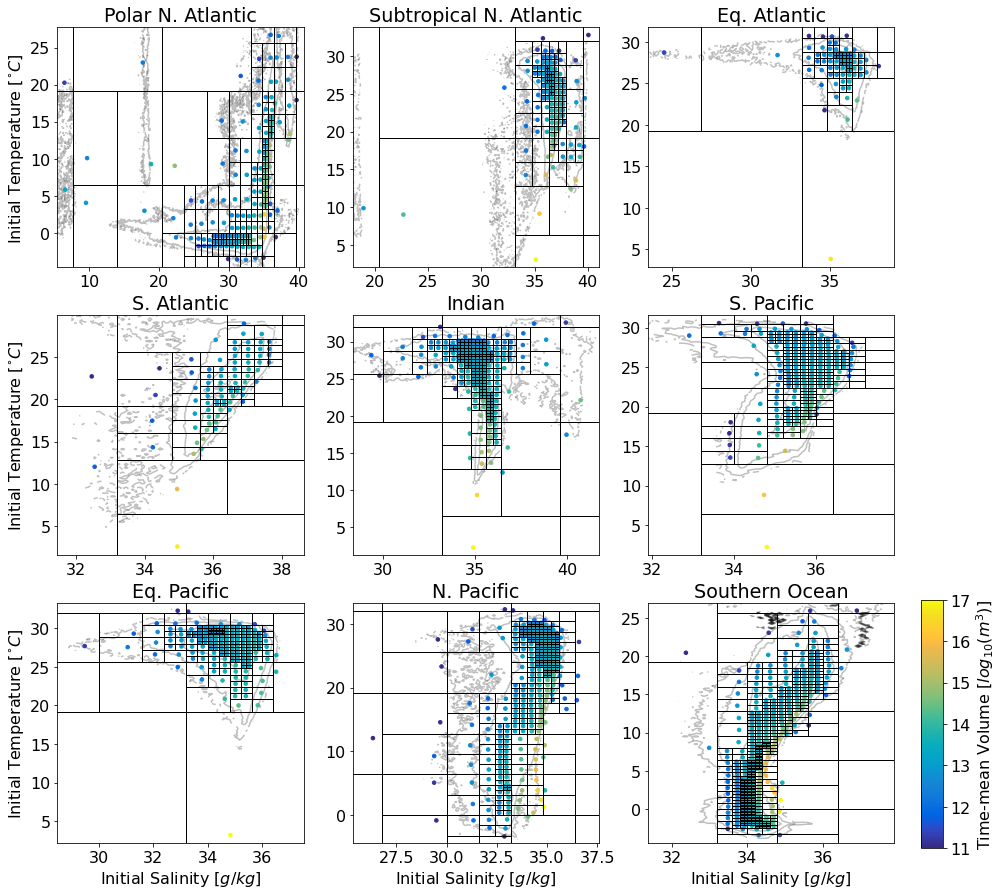

In [14]:
fig, axs = plt.subplots(3,3, figsize=(15,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

for i in range(Basins.size):
    XY = np.meshgrid(S_i, T_i)
    SA_flat = np.ndarray.flatten(XY[0])
    CT_flat = np.ndarray.flatten(XY[1])
    flat_A = np.ndarray.flatten(np.moveaxis(((A1+A2)/2)[:,:,i],0,-1))
    flat_A[np.isnan(flat_A)] = 0
    flat_A1 = np.ndarray.flatten(np.moveaxis(((A1))[:,:,i],0,-1))
    flat_A1[np.isnan(flat_A1)] = 0
    test = QTree(threshold, SA_flat, CT_flat, flat_A, flat_A1)
    test.subdivide()
    c = find_children(test.root)
    areas = set()
    for el in c:
        areas.add(el.width*el.height)
    for n in c:
        axs[i].add_patch(patches.Rectangle((n.x0, n.y0), n.width, n.height, fill=False))
    x = [point.x for point in test.data]
    y = [point.y for point in test.data]
    w = [point.w for point in test.data]
    v1 = [point.v1 for point in test.data]
    im = axs[i].scatter(S_avg1[i],T_avg1[i],50,\
                   np.log10((qtout_basins_vol1[i][:,0]+qtout_basins_vol2[i][:,0])/2),\
                   cmap=parula_map, vmin=11, vmax=17, marker = '.')
    axs[i].set_ylim(np.nanmin(T_avg1[i])-1, np.nanmax(T_avg1[i])+1)
    axs[i].set_xlim(np.nanmin(S_avg1[i])-1, np.nanmax(S_avg1[i])+1)
    axs[i].contour(S_i,T_i,np.moveaxis(np.log10(((A1[:,:,i]+A2[:,:,i])/2)/(dS_grid*dT_grid)),0,-1), \
                  colors='black', levels = np.arange(0,100), zorder=0, alpha=0.25)
    axs[i].set_title(bloc[Basins[i]]['name'])
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Initial Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Initial Salinity [$g/kg$]')

        
m = plt.cm.ScalarMappable(cmap=parula_map)
m.set_array(np.log10((qtout_basins_vol1[i][:,0]+qtout_basins_vol2[i][:,0])/2))
m.set_clim(11, 17)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Time-mean Volume [$log_{10}(m^3)$]') 
plt.savefig('../../Figures/QTree_9basins.png', dpi=300, bbox_inches='tight')
plt.show()

-----
# Define a cost function and minimize using 'cvxpy' to find minimal surface flux
-----

We have two volumetric distributions characterised by a discrete set of water masses with volumes, average T and average S for an early and late period. We now find the minimum surface flux (in a least squares sense) that can explain the change in the distribution from the early period to the late period using Python's cvxpy function.

## Define a matrix of connectivity between the pre-defined basins, where 0 = connected and 1 = not connected

|  | Polar N. Atlantic  | Subtropical N. Atlantic | Eq. Atlantic | S. Atlantic | Indian | S. Pacific | Eq. Pacific | N. Pacific | Southern Ocean
| ------------- | -------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|
| **Polar N. Atlantic**   |  0 |0 |1 |1 |1 |1 |1 |1 |1 |
| **Subtropical N. Atlantic**   |  0 |0 |0 |1 |1 |1 |1 |1 |1 |
| **Eq. Atlantic**   |  1 |0 |0 |0 |1 |1 |1 |1 |1 |
| **S. Atlantic**   |  1 |1 |0 |0 |1 |1 |1 |1 |0 |
| **Indian**   |  1 |1 |1 |1 |0 |1 |0 |1 |0 |
| **S. Pacific**   |  1 |1 |1 |1 |1 |0 |0 |1 |0 |
| **Eq. Pacific**   |  1 |1 |1 |1 |0 |0 |0 |0 |1 |
| **N. Pacific**   |  1 |1 |1 |1 |1 |1 |0 |0 |1 |
| **Southern Ocean**   |  1 |1 |1 |0 |0 |0 |1 |1 |0 |

<p><center>Table: The connectivity between basins, where 0 = connected and 1 = not connected</center></p>



## Convert the watermasses into one long vector of volumes, temperatures, salinities and areas 

In [15]:
Vol_blc1 = []
Vol_blc2 = []
A_blc1 = []
A_blc2 = []
S_blc1 = []
S_blc2 = []
T_blc1 = []
T_blc2 = []
Basin_blc1 = []
Basin_blc2 = []

connectivity_array = np.zeros((np.array(Basins).size, np.array(Basins).size))
for i in range(np.array(Basins).size):
    for j in range(np.array(Basins).size):
        connectivity_array[i,j] = bloc[Basins[i]]['connec'][j]

for i in range(np.array(Basins).size):
    Vol_blc1.append(qtout_basins_vol1[i][:,0])
    Vol_blc2.append(qtout_basins_vol2[i][:,0])
    A_blc1.append(qtout_basins_area1[i][:,0])
    A_blc2.append(qtout_basins_area2[i][:,0])
    S_blc1.append(S_avg1[i])
    S_blc2.append(S_avg2[i])
    T_blc1.append(T_avg1[i])
    T_blc2.append(T_avg2[i])
    Basin_blc1.append(i*np.ones(qtout_basins_vol1[i][:,0].size))
    Basin_blc2.append(i*np.ones(qtout_basins_vol2[i][:,0].size))

flat_Vol_blc1 = np.array([item for sublist in Vol_blc1 for item in sublist])
flat_Vol_blc2 = np.array([item for sublist in Vol_blc2 for item in sublist])
flat_A_blc1 = np.array([item for sublist in A_blc1 for item in sublist])
flat_A_blc2 = np.array([item for sublist in A_blc2 for item in sublist])
flat_S_blc1 = np.array([item for sublist in S_blc1 for item in sublist])
flat_S_blc2 = np.array([item for sublist in S_blc2 for item in sublist])
flat_T_blc1 = np.array([item for sublist in T_blc1 for item in sublist])
flat_T_blc2 = np.array([item for sublist in T_blc2 for item in sublist])
flat_Basin_blc1 = np.array([item for sublist in Basin_blc1 for item in sublist])
flat_S_st_basin = np.array([item for sublist in S_st_basin for item in sublist])
flat_S_end_basin = np.array([item for sublist in S_end_basin for item in sublist])
flat_T_st_basin = np.array([item for sublist in T_st_basin for item in sublist])
flat_T_end_basin = np.array([item for sublist in T_end_basin for item in sublist])

flat_S_blc1[np.isnan(flat_S_blc1)] = 0
flat_S_blc2[np.isnan(flat_S_blc2)] = 0
flat_T_blc1[np.isnan(flat_T_blc1)] = 0
flat_T_blc2[np.isnan(flat_T_blc2)] = 0

In [16]:
print('Total number of quadtree bins =', int(flat_Vol_blc1.shape[0]))

Total number of quadtree bins = 2076


## Define a matrix of distances between each of the quadtree bins in each basin.

In [17]:
%%time
connected = np.zeros((flat_Vol_blc1.size, flat_Vol_blc1.size))
connected_Sst = np.zeros_like(connected)
connected_Tst = np.zeros_like(connected)
connected_Send = np.zeros_like(connected)
connected_Tend = np.zeros_like(connected)
for i in tqdm(range(flat_Vol_blc1.size)):
    for j in range(flat_Vol_blc2.size):
        if connectivity_array[int(flat_Basin_blc1[i]), int(flat_Basin_blc1[j])]==0:
            if (flat_S_st_basin[i]<=flat_S_end_basin[j] and flat_S_st_basin[i]>=flat_S_st_basin[j]\
            and flat_T_st_basin[i]<=flat_T_end_basin[j] and flat_T_st_basin[i]>=flat_T_st_basin[j]) or\
            (flat_S_end_basin[i]<=flat_S_end_basin[j] and flat_S_end_basin[i]>=flat_S_st_basin[j]\
            and flat_T_st_basin[i]<=flat_T_end_basin[j] and flat_T_st_basin[i]>=flat_T_st_basin[j]) or\
            (flat_S_end_basin[i]<=flat_S_end_basin[j] and flat_S_end_basin[i]>=flat_S_st_basin[j]\
            and flat_T_end_basin[i]<=flat_T_end_basin[j] and flat_T_end_basin[i]>=flat_T_st_basin[j]) or\
            (flat_S_st_basin[i]<=flat_S_end_basin[j] and flat_S_st_basin[i]>=flat_S_st_basin[j]\
            and flat_T_end_basin[i]<=flat_T_end_basin[j] and flat_T_end_basin[i]>=flat_T_st_basin[j]) or\
            (flat_S_st_basin[j]<=flat_S_end_basin[i] and flat_S_st_basin[j]>=flat_S_st_basin[i]\
            and flat_T_st_basin[j]<=flat_T_end_basin[i] and flat_T_st_basin[j]>=flat_T_st_basin[i]) or\
            (flat_S_end_basin[j]<=flat_S_end_basin[i] and flat_S_end_basin[j]>=flat_S_st_basin[i]\
            and flat_T_st_basin[j]<=flat_T_end_basin[i] and flat_T_st_basin[j]>=flat_T_st_basin[i]) or\
            (flat_S_end_basin[j]<=flat_S_end_basin[i] and flat_S_end_basin[j]>=flat_S_st_basin[i]\
            and flat_T_end_basin[j]<=flat_T_end_basin[i] and flat_T_end_basin[j]>=flat_T_st_basin[i]) or\
            (flat_S_st_basin[j]<=flat_S_end_basin[i] and flat_S_st_basin[j]>=flat_S_st_basin[i]\
            and flat_T_end_basin[j]<=flat_T_end_basin[i] and flat_T_end_basin[j]>=flat_T_st_basin[i]):
                connected[i,j] = 1
                connected_Sst[i,j] = flat_S_st_basin[i]
                connected_Send[i,j] = flat_S_st_basin[i]
                connected_Tend[i,j] = np.nanmin(np.array([flat_T_end_basin[i],flat_T_end_basin[j]]))
                connected_Tst[i,j] = np.nanmax(np.array([flat_T_st_basin[i],flat_T_st_basin[j]]))

  0%|          | 0/2076 [00:00<?, ?it/s]

CPU times: user 9.07 s, sys: 61.3 ms, total: 9.13 s
Wall time: 9.05 s


## Define cost function and constraints for minimization

In [18]:
nofaces = np.nansum(connected)
A1_connec=np.zeros((flat_Vol_blc1.size,int(nofaces)))
A2_connec=np.zeros((flat_Vol_blc2.size,int(nofaces)))
# Also make T and S matrix with the T(k,i) the temp of the ith early WM
Tmatrix=np.zeros((flat_Vol_blc2.size,int(nofaces)))
Smatrix=np.zeros((flat_Vol_blc2.size,int(nofaces)))
ix=0
for i in range(flat_Vol_blc1.size):
    for j in range(flat_Vol_blc2.size):
        if connected[i,j]==1:
            A1_connec[i,ix]=1 #vertex ix connects from WM i
            A2_connec[j,ix]=1 #vertex ix connects to WM j
            Tmatrix[j,ix] = flat_T_blc1[i] #vertex ix brings temp of WM i to WM j
            Smatrix[j,ix] = flat_S_blc1[i] #vertex ix brings temp of WM i to WM j
            ix=ix+1

xnorming = 10**15 #normalising coeffcients
Areanorming = 10**12 #normalising coeffcients
AA = np.concatenate((A1_connec,A2_connec),axis=0)
CC_T = np.zeros_like(Tmatrix)
CC_S = np.zeros_like(Tmatrix)
for i in range(int(nofaces)):
    CC_T[:,i] = Areanorming*Tmatrix[:,i]/(flat_A_blc2+10**10)
    CC_S[:,i] = Areanorming*ST_scale*(Smatrix[:,i])/(flat_A_blc2+10**10)
CC = np.concatenate((CC_T,CC_S),axis=0)
#plus 10**10 to prevent divide by zero
bb = np.concatenate((flat_Vol_blc1/xnorming,flat_Vol_blc2/xnorming),axis=0)
bb = bb.T
dd = Areanorming*np.concatenate((flat_Vol_blc2*flat_T_blc2/(flat_A_blc2+10**10),\
                           ST_scale*flat_Vol_blc2*flat_S_blc2/(flat_A_blc2+10**10)), axis=0)/xnorming

dd[np.isnan(dd)]=0

-----
# Perform a Least-Squares Minimimization 
## of the cost function, subject to the constraints
-----

In [78]:
%%time
m = CC.shape[0]
n = CC.shape[1]

A = CC
C = AA
d = bb
b = dd
x = cp.Variable(n, nonneg=True)

cost = 0.5*cp.norm(A @ x - b, p=2)
constraints = [C@x == d]
prob = cp.Problem(cp.Minimize(cost), constraints)

# The optimal objective value is returned by prob.solve()`.
# Note, the default tolerances may be too tight for the minimization, so this step involves some trial-and-error of tolerances to get the minimization to work
result = prob.solve(verbose = True, solver=cp.ECOS,feastol=1e-4, reltol=1e-8, abstol=1e+2)#, max_iters=100, feastol=2.4e-05, reltol=1.1e+00, abstol=5.3e+01)# feastol=9.5e-04, reltol=9.9e-01, abstol=9.7e+02)#, feastol=9.9e-4, reltol=1e-3, abstol=1e-8)

# The optimal value for x is stored in `x.value`.
xxx=x.value

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 15 11:54:09 AM: Your problem has 32390 variables, 1 constraints, and 0 parameters.
(CVXPY) Jul 15 11:54:09 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 15 11:54:09 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 15 11:54:09 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 15 11:54:09 AM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 15 11:54:09 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [79]:
Tmixed = np.matmul(Tmatrix,xxx)/(flat_Vol_blc2/xnorming)
Tmixed[~np.isfinite(Tmixed)]=0
Smixed = np.matmul(Smatrix,xxx)/(flat_Vol_blc2/xnorming)
Smixed[~np.isfinite(Smixed)]=0;
# Now the necessary heat and salt adjustment is simply the difference
# between this and what we actually get
dTV_adj = (flat_T_blc2-Tmixed)*flat_Vol_blc2
dSV_adj = (flat_S_blc2-Smixed)*flat_Vol_blc2

# Furthermore we want to know how much T and S change the mixing actually
# causes for the early water masses as they turn into late water masses.
ix=0
dT_between=np.zeros((flat_Vol_blc2.size,int(nofaces)))
dS_between=np.zeros((flat_Vol_blc2.size,int(nofaces)))
for i in range(flat_Vol_blc1.size):
    for j in range(flat_Vol_blc2.size):
        if connected[i,j]==1:
            dT_between[i,ix] = Tmixed[j]-flat_T_blc1[i]
            #temp where it gets to minus where it came from
            dS_between[i,ix] = Smixed[j]-flat_S_blc1[i]
            ix=ix+1

dTV_mix = np.matmul(dT_between,xxx)*xnorming
dSV_mix = np.matmul(dS_between,xxx)*xnorming
# Dividing by the volume we get the average temperature change.
T_Av_adj = dTV_adj/(flat_Vol_blc2)
T_Av_adj[np.isnan(T_Av_adj)] = 0
S_Av_adj = dSV_adj/(flat_Vol_blc2)
S_Av_adj[np.isnan(S_Av_adj)]= 0

# Do the same for the mixing onto the early WMs
T_Av_mix = dTV_mix/(flat_Vol_blc1)
T_Av_mix[np.isnan(T_Av_mix)] = 0
T_Av_mix[T_Av_mix==np.inf] = 0
S_Av_mix = dSV_mix/(flat_Vol_blc1)
S_Av_mix[np.isnan(S_Av_mix)]= 0
S_Av_mix[S_Av_mix==np.inf] = 0

## Plot the minimal surface fluxes inferred from the optimization in TS space

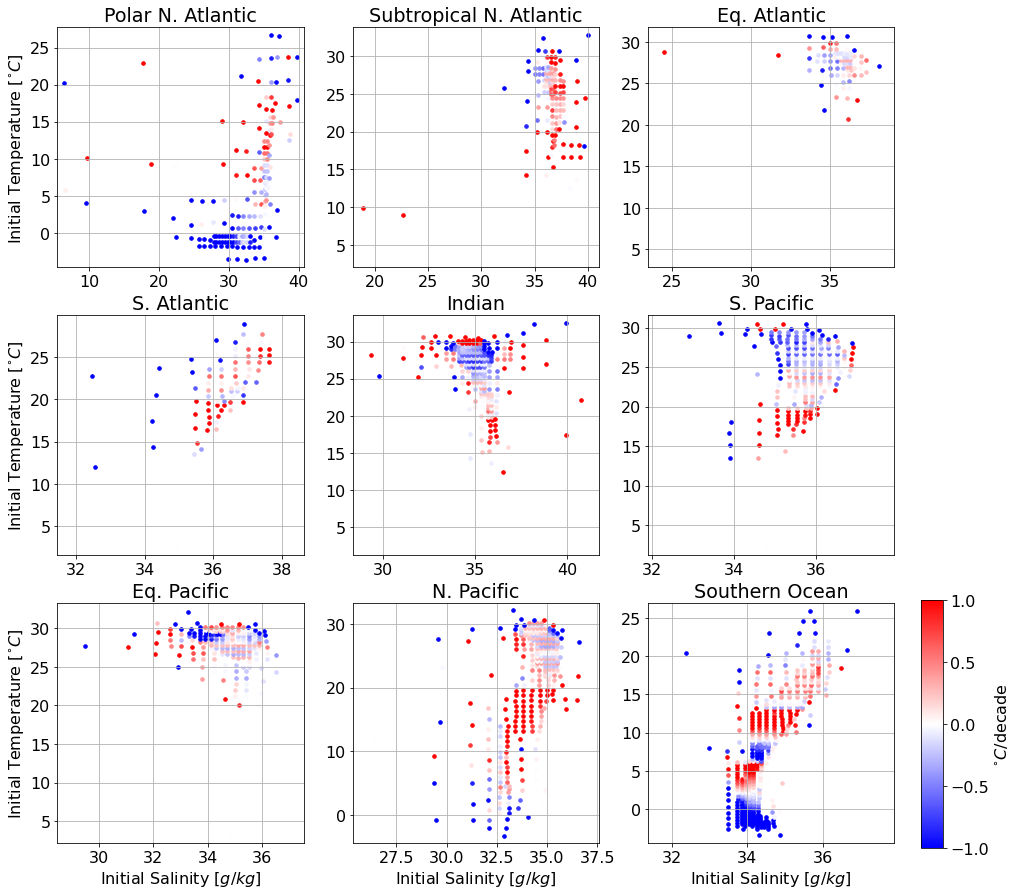

CPU times: user 38.9 s, sys: 310 ms, total: 39.2 s
Wall time: 39.2 s


In [80]:
%%time
fig, axs = plt.subplots(3,3, figsize=(15,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

k=0
for i in range(np.array(Basins).size):
    for j in range(qtout_basins_vol1[i][:,0].size):
        axs[i].scatter(flat_S_blc1[k], flat_T_blc1[k], 50, 10*T_Av_adj[k]/dyrs, '.', vmin=-1, vmax=1, cmap='bwr')
        axs[i].set_ylim(np.nanmin(T_avg1[i])-1, np.nanmax(T_avg1[i])+1)
        axs[i].set_xlim(np.nanmin(S_avg1[i])-1, np.nanmax(S_avg1[i])+1)
        axs[i].set_title(bloc[Basins[i]]['name'])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Initial Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Initial Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(-1,1)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$/decade') 
plt.savefig('../../Figures/Minimisation_9basins.png', dpi=300, bbox_inches='tight')
plt.show()

## Plot the minimal surface fluxes and mixing inferred from the optimization as vectors in TS space

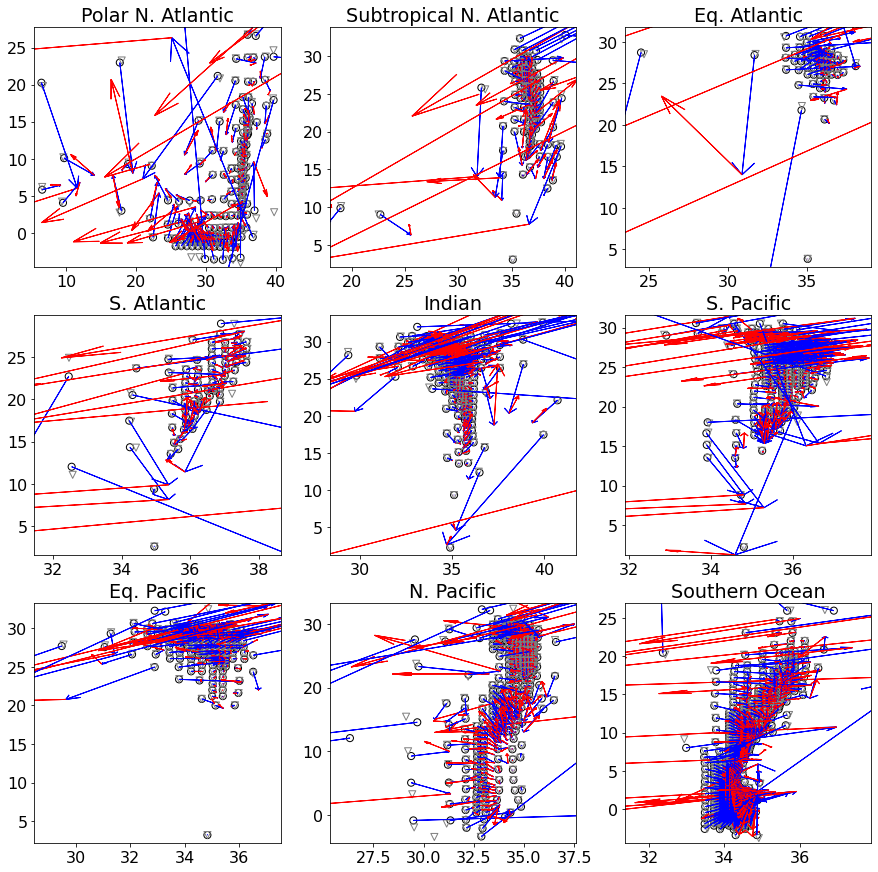

CPU times: user 9.47 s, sys: 193 ms, total: 9.66 s
Wall time: 9.61 s


In [81]:
%%time
fig, axs = plt.subplots(3,3, figsize=(15,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 

k=0
for i in range(np.array(Basins).size):
    axs[i].scatter(S_avg1[i],T_avg1[i],\
                   s=50,\
                    marker = 'o', facecolor='none', edgecolor='black', label = 't1')
    axs[i].scatter(S_avg2[i],T_avg2[i],\
               s=50,\
              marker = 'v', facecolor='none', edgecolor='grey', label = 't2')
    for j in range(qtout_basins_vol1[i][:,0].size):
        hyp_mix = np.sqrt(S_Av_mix[k]**2+T_Av_mix[k]**2)
        hyp_adj = np.sqrt(S_Av_adj[k]**2+T_Av_adj[k]**2)
        axs[i].arrow(flat_S_blc1[k], flat_T_blc1[k], S_Av_mix[k], T_Av_mix[k], color='blue', \
                     length_includes_head = True, head_length=hyp_mix*.1, head_width = hyp_mix*.1, overhang = 1, label = 'Mixing')
        axs[i].arrow(flat_S_blc1[k]+S_Av_mix[k], flat_T_blc1[k]+T_Av_mix[k], S_Av_adj[k], T_Av_adj[k], color='red', \
                     length_includes_head = True, head_length=hyp_adj*.2, head_width = hyp_adj*.1, overhang = 1, label = 'Surface Fluxes')
        axs[i].set_ylim(np.nanmin(T_avg1[i])-1, np.nanmax(T_avg1[i])+1)
        axs[i].set_xlim(np.nanmin(S_avg1[i])-1, np.nanmax(S_avg1[i])+1)
        axs[i].set_title(bloc[Basins[i]]['name'])
        k=k+1

plt.savefig('../../Figures/Minimisation_vectors.png', dpi=300, bbox_inches='tight')
plt.show()

----
# Remap the optimized mixing, surface fluxes and circulation changes in geographic space
----

In [82]:
%%time
T_Av_adj_grid = np.zeros_like(V2)
S_Av_adj_grid = np.zeros_like(V2)

k=0
for i in range(np.array(Basins).size):
    WTgrid=np.zeros_like(V2[:,:,0])
    WSgrid=np.zeros_like(V2[:,:,0])
    for j in range(qtout_basins_vol1[i][:,0].size):
        WTgrid = np.where(np.logical_and(np.logical_and(np.logical_and(\
                              T_grid>flat_T_st_basin[k],T_grid<flat_T_end_basin[k]), \
                              S_grid>flat_S_st_basin[k]),S_grid<flat_S_end_basin[k]),\
                              T_Av_adj[k], WTgrid)
        WSgrid = np.where(np.logical_and(np.logical_and(np.logical_and(\
                          T_grid>flat_T_st_basin[k],T_grid<flat_T_end_basin[k]), \
                          S_grid>flat_S_st_basin[k]),S_grid<flat_S_end_basin[k]),\
                          S_Av_adj[k], WSgrid)
        k=k+1
    

    T_Av_adj_grid[:,:,i] = WTgrid.T
    S_Av_adj_grid[:,:,i] = WSgrid.T

dT_adj_basin=np.zeros((vol.shape[0], vol.shape[1], vol.shape[2], np.array(Basins).size))
dS_adj_basin=np.zeros((vol.shape[0], vol.shape[1], vol.shape[2], np.array(Basins).size))

CPU times: user 2.59 s, sys: 29 ms, total: 2.62 s
Wall time: 2.62 s


In [83]:
%%time
for i in tqdm(range(np.array(Basins).size)):
    DT1=np.zeros_like(vol)
    WTgrid=T_Av_adj_grid[:,:,i]
    WTgrid[np.isnan(WTgrid)]=0
    DS1=np.zeros_like(vol)
    WSgrid=S_Av_adj_grid[:,:,i]
    WSgrid[np.isnan(WSgrid)]=0
    for timx in range(CTlate.shape[-1]):
        T = CTlate[:,:,:,timx]
        S = SAlate[:,:,:,timx]
        
        T_masked = np.where((bloc[Basins[i]]['mask']==0), -100, T)
        S_masked = np.where((bloc[Basins[i]]['mask']==0), -100, S)

        tx = np.digitize(T_masked, T_i)
        sx =  np.digitize(S_masked, S_i)
        sx[sx==0]=1
        tx[tx==0]=1

        DT1 = DT1+np.array(list(WTgrid[tx-1,sx-1]))
        DS1 = DS1+np.array(list(WSgrid[tx-1,sx-1]))

    dT_adj_basin[:,:,:,i] = bloc[Basins[i]]['mask']*DT1/timx
    dS_adj_basin[:,:,:,i] = bloc[Basins[i]]['mask']*DS1/timx

# Now add over all the basins and we have the material warming. Voila!
dT_adj = np.nansum(dT_adj_basin, axis=-1)
dS_adj = np.nansum(dS_adj_basin, axis=-1)

# make sure non-ocean parts are NaNs.
dT_adj[np.isnan(CTlate[:,:,:,0])]=np.nan
dS_adj[np.isnan(CTlate[:,:,:,0])]=np.nan

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 1min 20s, sys: 5.51 s, total: 1min 26s
Wall time: 1min 26s


In [84]:
%%time
# Project T mixing onto geographical locations of early water masses
# Now that we know how much we need to warm each of the early water masses
# (defined based on which region it is in and what its T and S limits are)
# we can project these changes back to the actual geographical location of
# the watermass themselves.
T_Av_mix_grid = np.zeros_like(V1)
S_Av_mix_grid = np.zeros_like(V1)

k=0
for i in range(np.array(Basins).size):
    WTgrid=np.zeros_like(V1[:,:,0])
    WSgrid=np.zeros_like(V1[:,:,0])
    for j in range(qtout_basins_vol1[i][:,0].size):
        WTgrid = np.where(np.logical_and(np.logical_and(np.logical_and(\
                              T_grid>flat_T_st_basin[k],T_grid<flat_T_end_basin[k]), \
                              S_grid>flat_S_st_basin[k]),S_grid<flat_S_end_basin[k]),\
                              T_Av_mix[k], WTgrid)
        WSgrid = np.where(np.logical_and(np.logical_and(np.logical_and(\
                          T_grid>flat_T_st_basin[k],T_grid<flat_T_end_basin[k]), \
                          S_grid>flat_S_st_basin[k]),S_grid<flat_S_end_basin[k]),\
                          S_Av_mix[k], WSgrid)
        k=k+1
    

    T_Av_mix_grid[:,:,i] = WTgrid.T
    S_Av_mix_grid[:,:,i] = WSgrid.T

dT_mix_basin=np.zeros((vol.shape[0], vol.shape[1], vol.shape[2], np.array(Basins).size))
dS_mix_basin=np.zeros((vol.shape[0], vol.shape[1], vol.shape[2], np.array(Basins).size))
for i in tqdm(range(np.array(Basins).size)):
    DT1=np.zeros_like(vol)
    WTgrid=T_Av_mix_grid[:,:,i]
    WTgrid[np.isnan(WTgrid)]=0
    DS1=np.zeros_like(vol)
    WSgrid=S_Av_mix_grid[:,:,i]
    WSgrid[np.isnan(WSgrid)]=0
    for timx in range(CTlate.shape[-1]):
        T = CTearly[:,:,:,timx]
        S = SAearly[:,:,:,timx]
        
        T_masked = np.where((bloc[Basins[i]]['mask']==0), -100, T)
        S_masked = np.where((bloc[Basins[i]]['mask']==0), -100, S)
        tx = np.digitize(T_masked,T_i)
        sx = np.digitize(S_masked,S_i)
        sx[sx==0]=1
        tx[tx==0]=1
        DT1 = DT1+list(WTgrid[tx-1,sx-1])
        DS1 = DS1+list(WSgrid[tx-1,sx-1])

    dT_mix_basin[:,:,:,i] = (bloc[Basins[i]]['mask']*DT1)/timx
    dS_mix_basin[:,:,:,i] = (bloc[Basins[i]]['mask']*DS1)/timx

# Now average over all the basins and we have the material warming. Voila!
# Now add over all the basins and we have the material warming. Voila!
dT_mix = np.nansum(dT_mix_basin, axis=-1)
dS_mix = np.nansum(dS_mix_basin, axis=-1)

# make sure non-ocean parts are NaNs.
dT_mix[np.isnan(CTearly[:,:,:,0])]=np.nan
dS_mix[np.isnan(CTearly[:,:,:,0])]=np.nan

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 1min 24s, sys: 1.32 s, total: 1min 26s
Wall time: 1min 26s


# Mixing, Redistribution and Adjustment in
## Heat & Freshwater Content

In [85]:
# Compute Eulerian change in temperature (just a simple difference)
dT_eul=np.nanmean(CTlate-CTearly,axis=-1)
# Compute depth integrated heat content (units: W/m^2)
dH_mix = Cp*rho*np.nansum(dT_mix*vol,axis=-1)/(darea*dyrs*yr2sec)
dH_eul = Cp*rho*np.nansum(dT_eul*vol,axis=-1)/(darea*dyrs*yr2sec)
dH_adj = Cp*rho*np.nansum(dT_adj*vol,axis=-1)/(darea*dyrs*yr2sec)
dH_eul[dH_eul==0]=np.nan
dH_mix[dH_mix==0]=np.nan
dH_adj[dH_adj==0]=np.nan
dH_redist = dH_eul-dH_mix-dH_adj

# Compare Mixing, Redistribution and Adjustment fresh water change
# Compute Eulerian change in temperature (just a simple difference)
dS_eul=np.nanmean(SAlate-SAearly,axis=-1)
# Compute implied fresh water content change (units: mm/yr)
dW_mix = (-1/S0)*np.nansum(dS_mix*vol,axis=-1)/(darea*dyrs)
dW_eul = (-1/S0)*np.nansum(dS_eul*vol,axis=-1)/(darea*dyrs)
dW_adj = (-1/S0)*np.nansum(dS_adj*vol,axis=-1)/(darea*dyrs)
dW_eul[dW_eul==0]=np.nan
dW_mix[dW_mix==0]=np.nan
dW_adj[dW_adj==0]=np.nan
dW_redist = dW_eul - dW_mix - dW_adj

## Plot the remapped estimates

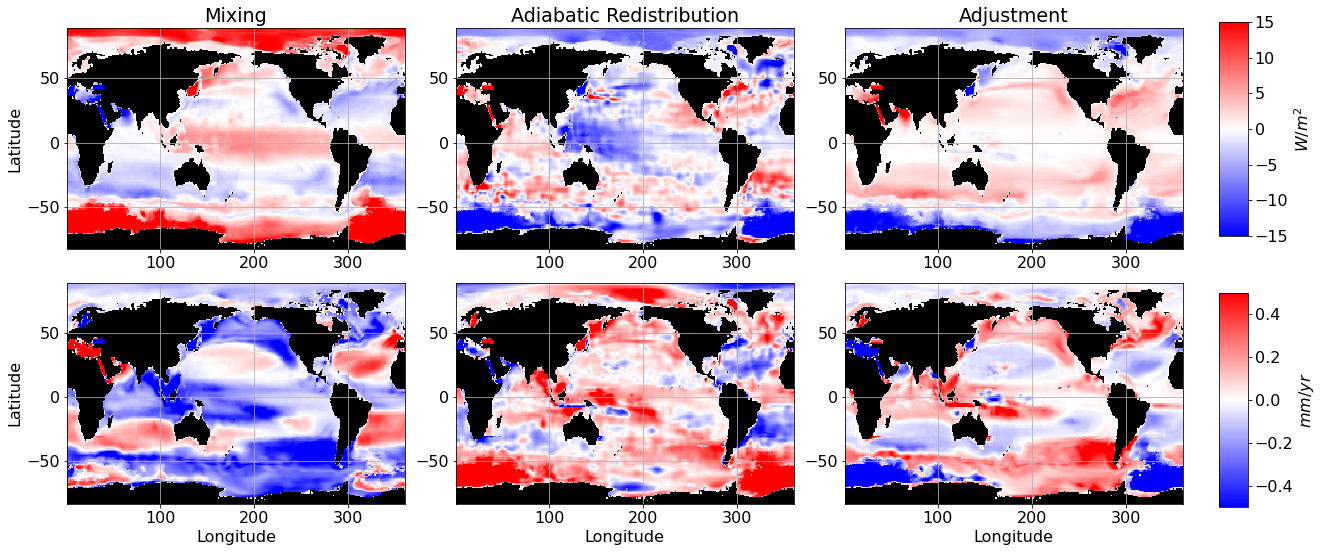

In [86]:
fig, axs = plt.subplots(2,3, figsize=(40*0.5,17.5*0.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .15, wspace=0.15)
axs = axs.ravel() 
cax1 = fig.add_axes([0.925, 0.55, 0.02, 0.34])
cax2 = fig.add_axes([0.925, 0.12, 0.02, 0.34])

axs[0].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))
axs[1].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))
axs[2].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))
axs[3].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))
axs[4].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))
axs[5].add_patch(patches.Rectangle((np.min(lon), np.min(lat)), lon.size, lat.size, color='black',zorder=0))

axs[0].pcolormesh(lon,lat,np.moveaxis(dH_mix, -1,0), vmin=-15,vmax=15, zorder=1,  cmap='bwr')
axs[1].pcolormesh(lon,lat,np.moveaxis(dH_redist, -1,0), vmin=-15, vmax=15, zorder=1, cmap='bwr')
axs[2].pcolormesh(lon,lat,np.moveaxis(dH_adj, -1,0), vmin=-15, vmax=15, zorder=1, cmap='bwr')
axs[3].pcolormesh(lon,lat,np.moveaxis(dW_mix, -1,0), vmin=-0.5,vmax=0.5, zorder=1,  cmap='bwr')
axs[4].pcolormesh(lon,lat,np.moveaxis(dW_redist, -1,0), vmin=-0.5, vmax=0.5, zorder=1, cmap='bwr')
axs[5].pcolormesh(lon,lat,np.moveaxis(dW_adj, -1,0), vmin=-0.5, vmax=0.5, zorder=1, cmap='bwr')

axs[0].grid(True, zorder=2)
axs[1].grid(True, zorder=2)
axs[2].grid(True, zorder=2)
axs[3].grid(True, zorder=2)
axs[4].grid(True, zorder=2)
axs[5].grid(True, zorder=2)

axs[0].set_title('Mixing')
axs[1].set_title('Adiabatic Redistribution')
axs[2].set_title(r'Adjustment')

axs[3].set_xlabel('Longitude')
axs[4].set_xlabel('Longitude')
axs[5].set_xlabel('Longitude')

axs[0].set_ylabel('Latitude')
axs[3].set_ylabel('Latitude')

axs[0].set_xlim(np.min(lon), np.max(lon))
axs[1].set_xlim(np.min(lon), np.max(lon))
axs[2].set_xlim(np.min(lon), np.max(lon))
axs[3].set_xlim(np.min(lon), np.max(lon))
axs[4].set_xlim(np.min(lon), np.max(lon))
axs[5].set_xlim(np.min(lon), np.max(lon))

axs[0].set_ylim(np.min(lat), np.max(lat))
axs[1].set_ylim(np.min(lat), np.max(lat))
axs[2].set_ylim(np.min(lat), np.max(lat))
axs[3].set_ylim(np.min(lat), np.max(lat))
axs[4].set_ylim(np.min(lat), np.max(lat))
axs[5].set_ylim(np.min(lat), np.max(lat))


m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(-0.5,0.5)
cbar2 = fig.colorbar(m, cax=cax2, orientation='vertical')
cbar2.set_label('$mm/yr$') 

m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(-15,15)
cbar1 = fig.colorbar(m, cax=cax1, orientation='vertical')
cbar1.set_label('$W/m^2$') 
plt.savefig('../../Figures/Minimisation_remapped.png', dpi=300, bbox_inches='tight')
plt.show()